In [183]:
# Import
import numpy as np
import time
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [184]:
# Select variable and buoy
fol = '../offline_data/mlwwcoast_prep_data'
myvar = 'u'
bb = 3

# Select forward back hrs [keep constant for now]
back = 24
forward = 24
fload = '{:s}/input_{:s}_buoy{:d}_back{:d}_for{:d}.npz'.format(fol,myvar,bb,back,forward)

# Keys in D
# X -> History Matrix (time,hr-back) where hr-back = 0,1,2,...
# Y -> Labels, (time,hr-forward) where hr_forward = 1,2,3... (pred we are trying to make)
# F -> Weather Forecast, (time,hr-forward)
# Fh -> Weather Forecast History, (time,hr-back)
# t -> time (time,)
# avg -> daily average, smoothed (time,1)


In [234]:
# Load and setup
D = np.load(fload)
t = D['t']
Y = D['Y']
X = D['X']
avg = D['avg']
F = D['F']
Fh = D['Fh']
R = Y - F

# Average Forecast RMSE for entire record 
np.sqrt(np.mean(np.power(F[:,0]-Y[:,0],2)))

1.7674263524991647

Text(0, 0.5, 'U/V [m/s]')

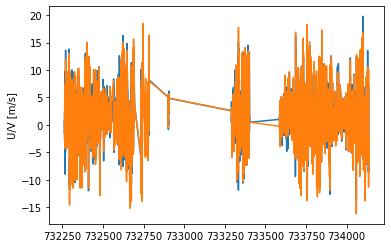

In [236]:
# Quick look at data, 
plt.plot(t,Y[:,0],label='observed')
plt.plot(t,F[:,0],label='forecast')
plt.ylabel('U/V [m/s]')

In [277]:
# Create fxns to test model and report rmse for train and test sets.
def test_model(model, X, y):
    x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size = 0.25, random_state = 42)
    model.fit(x_tr, y_tr)
    y_p = model.predict(x_te)
    y_tr_p = model.predict(x_tr)
    rmse_te = np.sqrt(np.mean(np.power(y_p-y_te,2), axis=0))
    rmse_tr = np.sqrt(np.mean(np.power(y_tr_p-y_tr,2), axis=0))
    return (rmse_te,rmse_tr)

# Similar to above, but using residuals
def test_model_residual(model, X, y, R, F):
    x_tr, x_te, y_tr, y_te, r_tr, r_te, f_tr, f_te = train_test_split(X, y, R, F, test_size = 0.25, random_state = 42)
    model.fit(x_tr, r_tr)
    y_p = f_te + model.predict(x_te)
    y_tr_p = f_tr + model.predict(x_tr)
    rmse_te = np.sqrt(np.mean(np.power(y_p-y_te,2), axis=0))
    rmse_tr = np.sqrt(np.mean(np.power(y_tr_p-y_tr,2), axis=0))
    return (rmse_te,rmse_tr)

# Baseline skill of numerical weather model
x_tr, x_te, yr_tr, yr_te, y_tr, y_te, f_tr, f_te = train_test_split(X, R, Y, F, test_size = 0.25, random_state = 42)
ref_rmse_te = np.sqrt(np.mean(np.power(y_te[:,0]-f_te[:,0],2)))
ref_rmse_tr = np.sqrt(np.mean(np.power(y_tr[:,0]-f_tr[:,0],2)))
ref_bias_te = np.mean(f_te[:,0]-y_te[:,0])
ref_bias_tr = np.mean(f_tr[:,0]-y_tr[:,0])
# Unbiased rmse
ref_rmse_nb_te = np.sqrt(np.mean(np.power(f_te[:,0]-y_te[:,0]-ref_bias_te,2)))
ref_rmse_nb_tr = np.sqrt(np.mean(np.power(f_tr[:,0]-y_tr[:,0]-ref_bias_tr,2)))

print([ref_rmse_tr, ref_rmse_te])
print([ref_bias_tr, ref_bias_te])
print([ref_rmse_nb_tr, ref_rmse_nb_te])

[1.7744025610705607, 1.7463305242229241]
[0.06550832181524058, 0.06774491312166486]
[1.773192913505667, 1.7450160247341142]


Numerical weather model rmse is 1.75 m/s for test set with a bias of 0.07 m/s (buoy = 3)

### Linear regression framework

$p_{t=1} = \alpha_1 o_{t=0} + \alpha_2 o_{t=-1} + ... + \alpha_{24} o_{t=-23} + \beta_1 f_{t=1} + \beta_2 f_{t=2} +   ...  + \beta_{23} f_{t=23}$ 
$p_{t=2} = \alpha_1 o_{t=0} + \alpha_2 o_{t=-1} + ... + \alpha_{24} o_{t=-23} + \beta_1 f_{t=1} + \beta_2 f_{t=2} +   ...  + \beta_{23} f_{t=23}$ 

$...$

$p_{t=23} = \alpha_1 o_{t=0} + \alpha_2 o_{t=-1} + ... + \alpha_{24} o_{t=-23} + \beta_1 f_{t=1} + \beta_2 f_{t=2} +   ...  + \beta_{23} f_{t=23}$ 

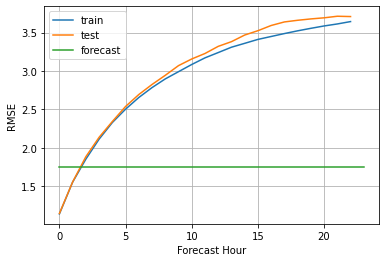

In [323]:
# Just obs
model = LinearRegression()
(rmse_te,rmse_tr) = test_model(model, X, Y)
plt.plot(rmse_tr, label = 'train')
plt.plot(rmse_te, label = 'test')
plt.plot([0,23],[ref_rmse_te,ref_rmse_te], label = 'forecast')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Forecast Hour')
plt.grid()

Predicting future hours with just prior observations: Skill for the first and second hours is better than forecast, but worse thereafter 

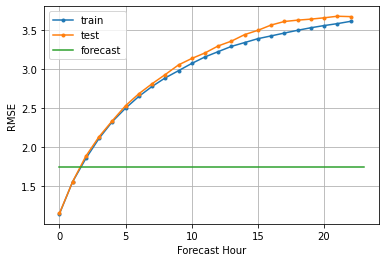

In [242]:
# Obs + Yearly Avg
model = LinearRegression()
(rmse_te,rmse_tr) = test_model(model, np.concatenate((X, avg), axis=1), Y)
plt.plot(rmse_tr, '.-', label = 'train')
plt.plot(rmse_te, '.-', label = 'test')
plt.plot([0,23],[ref_rmse_te,ref_rmse_te], label = 'forecast')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Forecast Hour')
plt.grid()

Adding the yearly average does not help

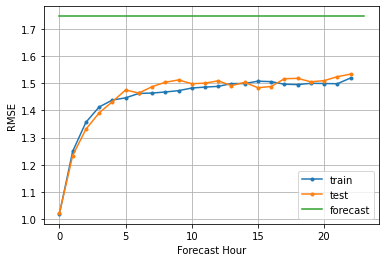

In [243]:
# Obs + future forecast
model = LinearRegression()
(rmse_te,rmse_tr) = test_model(model, np.concatenate((X,F), axis=1), Y)
plt.plot(rmse_tr, '.-', label = 'train')
plt.plot(rmse_te, '.-', label = 'test')
plt.plot([0,23],[ref_rmse_te,ref_rmse_te], label = 'forecast')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Forecast Hour')
plt.grid()

Add the future forecast hours (All 1-23 hours into the future for each regression) makes for significant improvement

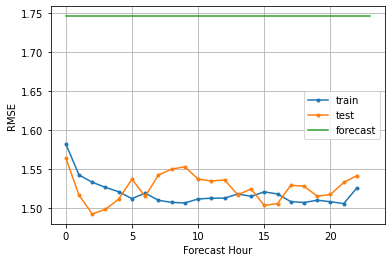

In [247]:
# Just future forecast
model = LinearRegression()
(rmse_te,rmse_tr) = test_model(model, F, Y)
plt.plot(rmse_tr, '.-', label = 'train')
plt.plot(rmse_te, '.-', label = 'test')
plt.plot([0,23],[ref_rmse_te,ref_rmse_te], label = 'forecast')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Forecast Hour')
plt.grid()

Using just forecast hours we get an improvement of ~ 0.20 - 0.25 m/s. This is interesting as it is slightly larger than the bias (0.07). Possibly some simple smoothing across forecast hours improves skill.

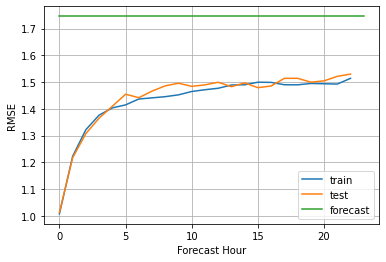

In [256]:
# Obs + future forecast + history forecast
model = LinearRegression()
(rmse_te,rmse_tr) = test_model(model, np.concatenate((X,F,Fh), axis=1), Y)
plt.plot(rmse_tr, label = 'train')
plt.plot(rmse_te, label = 'test')
plt.plot([0,23],[ref_rmse_te,ref_rmse_te], label = 'forecast')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Forecast Hour')
plt.grid()

Combining observations and future forecast improves skill quite a bit for hours < 6. Skill asymtopes around 1.5 m/s which was observed above

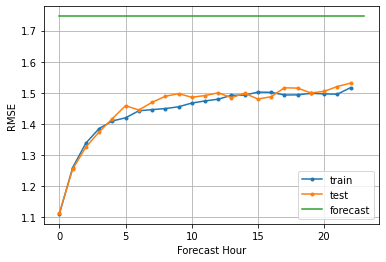

In [257]:
# future forecast + history residual 
model = LinearRegression()
(rmse_te,rmse_tr) = test_model(model, np.concatenate((X-Fh,F), axis=1), Y)
plt.plot(rmse_tr, '.-', label = 'train')
plt.plot(rmse_te, '.-', label = 'test')
plt.plot([0,23],[ref_rmse_te,ref_rmse_te], label = 'forecast')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Forecast Hour')
plt.grid()

### Summary thus far

Below we just look at test set RMSE

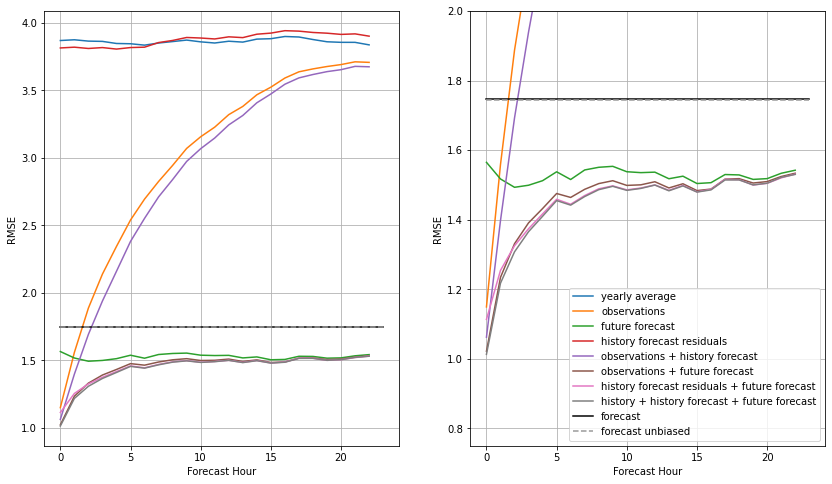

In [299]:
fig, axs = plt.subplots(1, 2, figsize=(14,8))

def make_plot(ax, model):
    # Observations
    (rmse_te,rmse_tr) = test_model(model, avg, Y)
    ax.plot(rmse_te, label = 'yearly average')

    (rmse_te,rmse_tr) = test_model(model, X, Y)
    ax.plot(rmse_te, label = 'observations')

    (rmse_te,rmse_tr) = test_model(model, F, Y)
    ax.plot(rmse_te, label = 'future forecast')

    (rmse_te,rmse_tr) = test_model(model, Fh-X, Y)
    ax.plot(rmse_te, label = 'history forecast residuals')

    (rmse_te,rmse_tr) = test_model(model, np.concatenate((X,Fh), axis=1), Y)
    ax.plot(rmse_te, label = 'observations + history forecast')

    (rmse_te,rmse_tr) = test_model(model, np.concatenate((X,F), axis=1), Y)
    ax.plot(rmse_te, label = 'observations + future forecast')

    (rmse_te,rmse_tr) = test_model(model, np.concatenate((X-Fh,F), axis=1), Y)
    ax.plot(rmse_te, label = 'history forecast residuals + future forecast')

    (rmse_te,rmse_tr) = test_model(model, np.concatenate((X,Fh,F), axis=1), Y)
    ax.plot(rmse_te, label = 'history + history forecast + future forecast')

    ax.plot([0,23],[ref_rmse_te,ref_rmse_te], label = 'forecast', color='k')
    ax.plot([0,23],[ref_rmse_nb_te,ref_rmse_nb_te], '--', label = 'forecast unbiased', color=[.6,.6,.6])

    ax.set_ylabel('RMSE')
    ax.set_xlabel('Forecast Hour')
    ax.grid()

model = LinearRegression()    
make_plot(axs[0],model)  
make_plot(axs[1],model)  
plt.ylim([.75,2])
plt.legend()

Takeaways (above all test set rmse)
 - yearly average is not useful
 - observations alone do well for first 2 hours, then forecast is better
 - linear combination of future forecast alone is around 20cm lower RMSE than forecast itself
 - history residuals not really useful alone
 - observations + history forecast only slightly better than observations alone
 - observations + future forecast quite good
 - Add history residuals or history forecast creates slight improvement

### Same analysis with MLP shows similar results

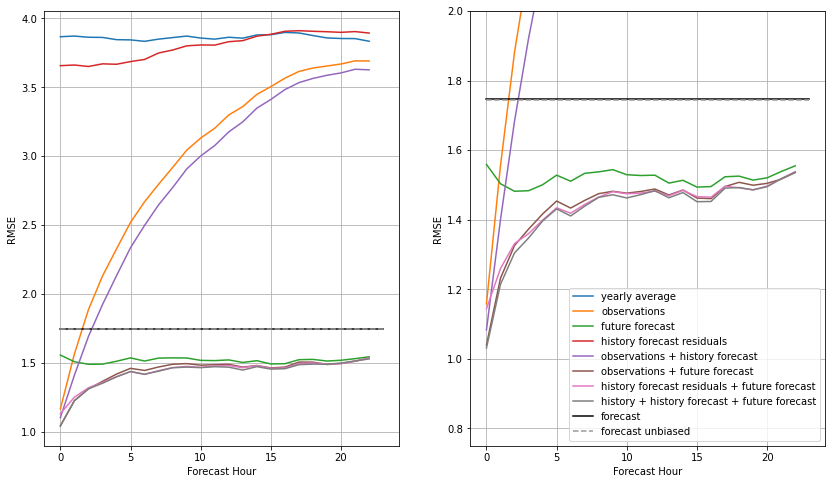

In [302]:
fig, axs = plt.subplots(1, 2, figsize=(14,8))
model = MLPRegressor(hidden_layer_sizes=25, max_iter=400) 
make_plot(axs[0],model)  
make_plot(axs[1],model)  
plt.ylim([.75,2])
plt.legend()

### Close look at the linear regression coefficients

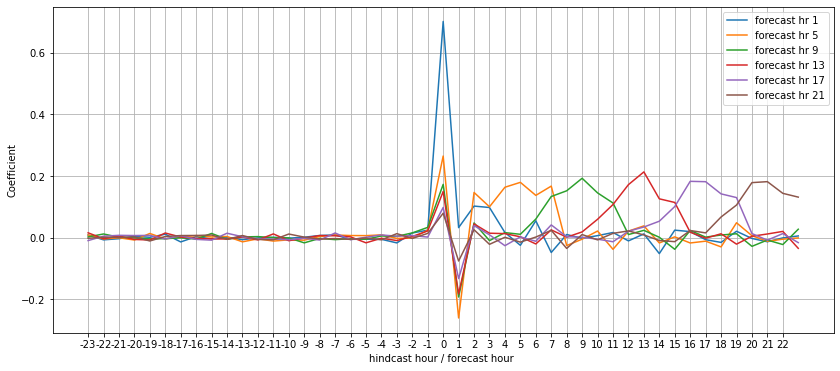

[0.03126469 0.05270741 0.06636611 0.07505669 0.08016946 0.08319518
 0.0848773  0.08571662 0.08739973 0.08988053 0.09126107 0.09234277
 0.09277754 0.09294907 0.09340498 0.09476202 0.09686959 0.09764651
 0.0976582  0.09809892 0.09927774 0.10409588 0.11581871]


In [320]:
# Close look at LinearRegresseion Coef
x_lab = np.arange(-23,23,1)
xaxis = np.concatenate((np.arange(0,-24,-1),np.arange(1,24,1)))
I = np.argsort(xaxis)

# Obs + Forecast
model = LinearRegression(normalize=False, fit_intercept=True)
model.fit(np.concatenate((X,F), axis=1), Y)

plt.figure(figsize=(14,6))

for h in range(0,24,4):
    plt.plot(xaxis[I], model.coef_[h,I], '-', label='forecast hr {:d}'.format(h+1))
plt.gca().set_xticks(x_lab)
plt.gca().set_xticklabels(x_lab)
plt.legend()
plt.ylabel('Coefficient')
plt.xlabel('hindcast hour / forecast hour ')
plt.grid()
plt.show()
print(model.intercept_)

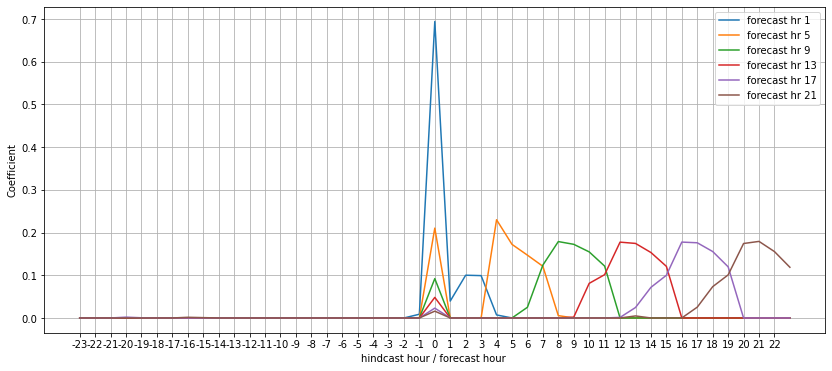

[0.05425483 0.0751859  0.08990894 0.10197611 0.11029558 0.11609657
 0.11992127 0.12186457 0.12336551 0.12524812 0.12758809 0.13000801
 0.13339423 0.13651175 0.13827075 0.14002378 0.14146906 0.14268085
 0.14267622 0.14260367 0.14249479 0.14692775 0.15863735]


In [321]:
# L1 penalty/normalization (lasso) to select out most useful model inputs (features)
# Obs + Forecast
from sklearn.linear_model import Lasso
model = Lasso(normalize=False, fit_intercept=True, alpha=.25)
model.fit(np.concatenate((X,F), axis=1), Y)

x_lab = np.arange(-23,23,1)
xaxis = np.concatenate((np.arange(0,-24,-1),np.arange(1,24,1)))
I = np.argsort(xaxis)

plt.figure(figsize=(14,6))

for h in range(0,24,4):
    plt.plot(xaxis[I], model.coef_[h,I], '-', label='forecast hr {:d}'.format(h+1))
plt.gca().set_xticks(x_lab)
plt.gca().set_xticklabels(x_lab)
plt.legend()
plt.ylabel('Coefficient')
plt.xlabel('hindcast hour / forecast hour ')
plt.grid()
plt.show()
print(model.intercept_)

### Summary stats

Note, inputs in same order as plot above, x24 is observation hour=0


In [326]:
import statsmodels.api as sm

# Regression for the first prediction hour
reg_in = np.concatenate((X,F), axis=1)
reg_in = reg_in[:,I]
est = sm.OLS(Y[:,0], reg_in)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              8251.
Date:                Mon, 17 Jan 2022   Prob (F-statistic):                        0.00
Time:                        13:47:54   Log-Likelihood:                         -36267.
No. Observations:               25208   AIC:                                  7.263e+04
Df Residuals:                   25161   BIC:                                  7.301e+04
Df Model:                          47                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [329]:
# Regression for the hour 6 in prediction
reg_in = np.concatenate((X,F), axis=1)
reg_in = reg_in[:,I]
est = sm.OLS(Y[:,6], reg_in)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              3729.
Date:                Mon, 17 Jan 2022   Prob (F-statistic):                        0.00
Time:                        13:49:37   Log-Likelihood:                         -45377.
No. Observations:               25208   AIC:                                  9.085e+04
Df Residuals:                   25161   BIC:                                  9.123e+04
Df Model:                          47                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------